In [62]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [206]:
path = "D:/data/SiPM/waveforms/20240506/pos_scan_line/"
filename_list = glob.glob(path + "Am241_28V_*.pkl")
template_file = "Am241_28V_x0.0_y0.0_*.pkl"
ov=28
save_figs = True

In [64]:
def parse_position(fname):
    file_parts = fname[:-4].split("_")
    x, y = float(file_parts[-3][1:]), float(file_parts[-2][1:])
    return x,y

In [65]:
ovs_dict = {}

ov_list = [ov]

fsample = 62.5e6 ## sampling rate in Hz
record_length = 129 ## not clear why this differs from the 128 set above
time_vec = np.arange(0, record_length/fsample, 1/fsample)

for j,ov in enumerate(ov_list):
    
    curr_files = glob.glob(os.path.join(path, template_file))
    
    data_dict = {}

    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for wf in curr_dict:

                sum_waveform = np.zeros_like(time_vec)	
                
                ## subtract baseline
                baseline = 2048 

                channel_dict = {}
                for k, ch in enumerate(range(16,-1,-2)):
                    channel_dict[k] = wf[ch] - baseline
                    sum_waveform += (wf[ch] - baseline)

                channel_dict[9] = sum_waveform

                data_dict[wfidx] = channel_dict
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + template_file)
    data_dict['time'] = time_vec*1e9

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}

Got 10230 waveforms for 10 files: Am241_28V_x0.0_y0.0_*.pkl


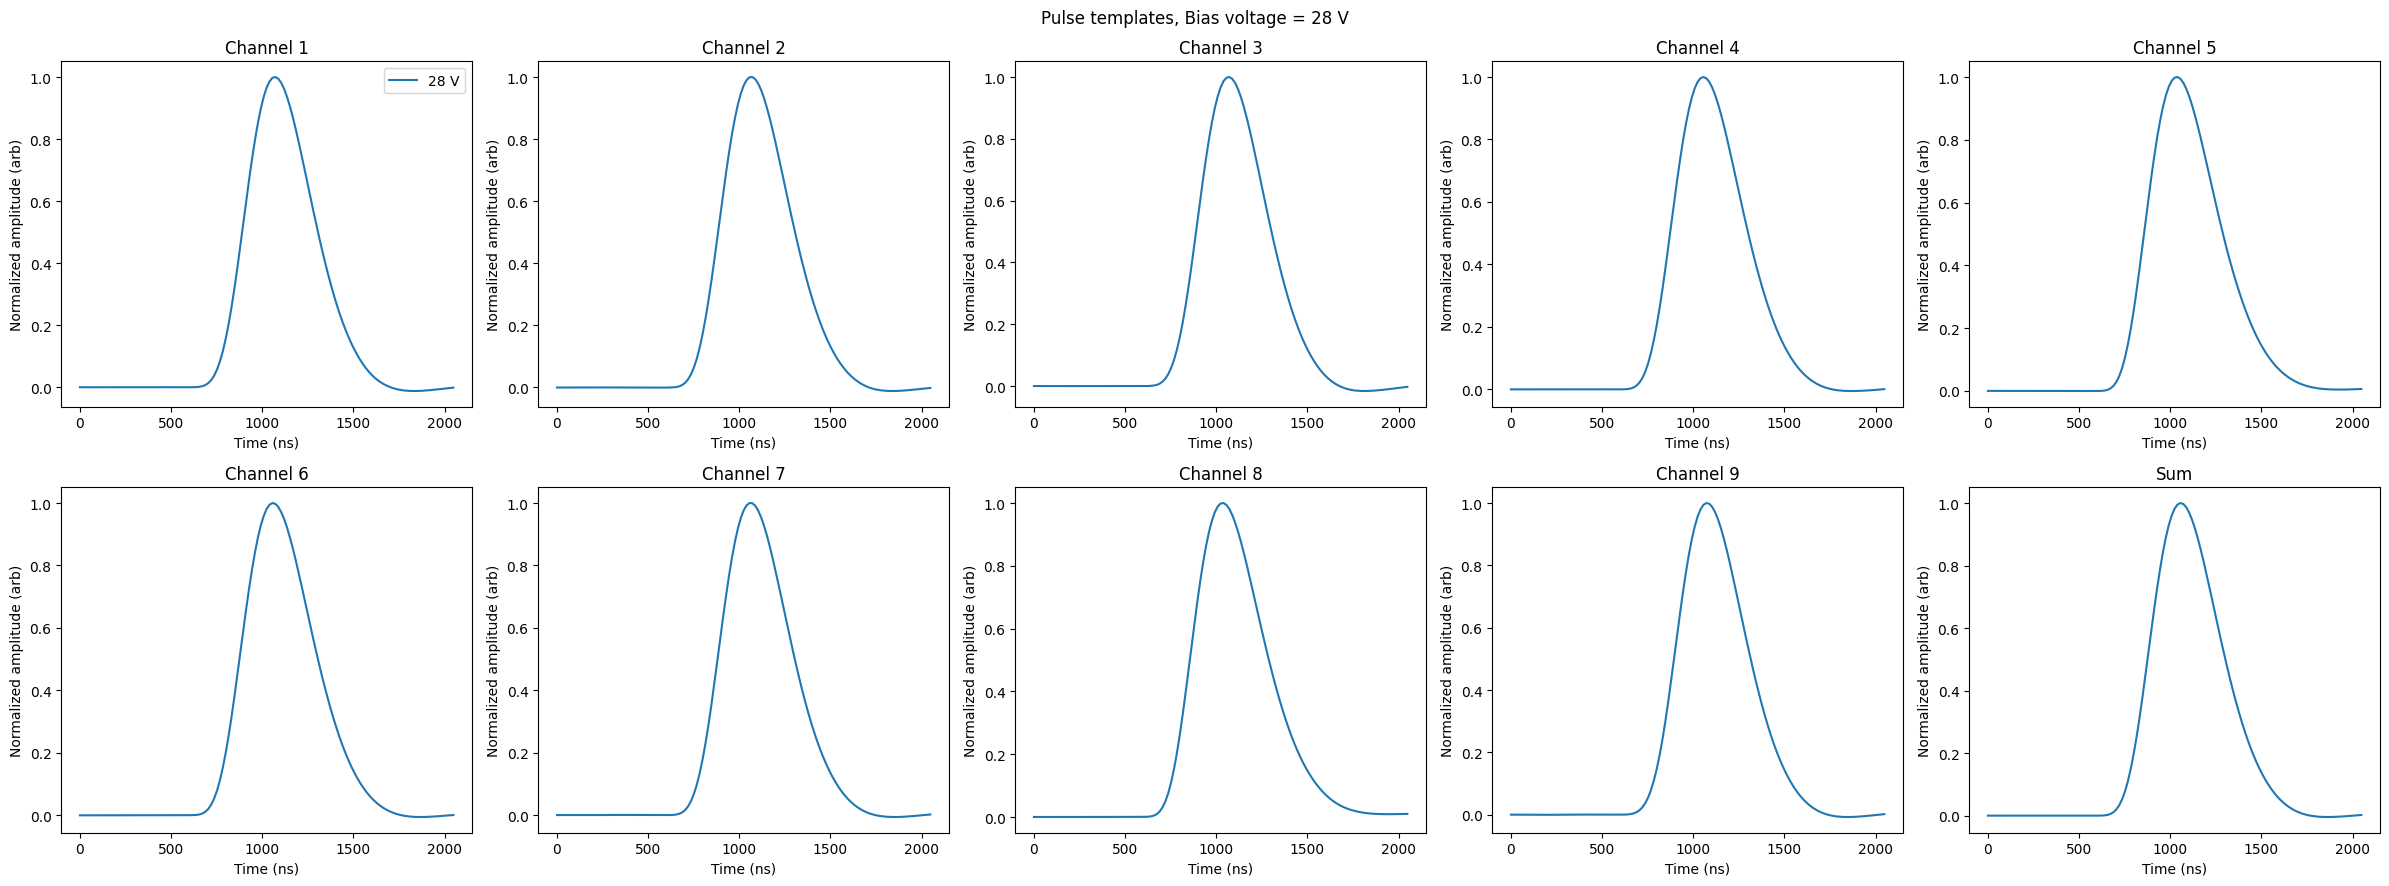

In [207]:
template_ch_dict = {}

min_vals = [200, 2000]

for ov in ov_list:

    plt.figure(figsize=(24,9))

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template_dict = {}
    nwfm = np.zeros(10)
    for ch in range(10):
        template_dict[ch] = np.zeros(len(data_dict['time']))

    for j in range(nwaveforms):

        cdat = data_dict[j]

        for ch in range(10):

            ## throw out bad traces
            min_val = min_vals[0] if ch < 9 else min_vals[1]
            if np.max(cdat[ch]) < min_val:
                continue

            template_dict[ch] += cdat[ch]
            nwfm[ch] += 1

    for ch in range(10):
        plt.subplot(2,5,ch+1)
        template_dict[ch] /= nwfm[ch]
        template_dict[ch] -= np.median(template_dict[ch][:20])
        template_dict[ch] /= np.max(template_dict[ch])

        plt.plot(data_dict['time'], template_dict[ch], label="%s V"%str(ov))
        plt.xlabel('Time (ns)')
        plt.ylabel('Normalized amplitude (arb)')

        if(ch < 9):
            plt.title("Channel %d"%(ch+1))
        else:
            plt.title("Sum")

    template_ch_dict[ov] = template_dict

    plt.suptitle("Pulse templates, Bias voltage = %s V"%str(ov))
    plt.subplot(2,5,1)
    plt.legend()
    plt.tight_layout()

    if(save_figs):
        plt.savefig(os.path.join(path, 'plots', 'templates.png') )

    plt.show()

In [67]:
xval_list = []
yval_list = []

for fidx, fname in enumerate(filename_list):

    xpos, ypos = parse_position(fname)

    if xpos not in xval_list:
        xval_list.append(xpos)

    if ypos not in yval_list:
        yval_list.append(ypos)

xval_list, yval_list = sorted(xval_list), sorted(yval_list)

print(xval_list, yval_list)


[-8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0] [0.0]


In [68]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [69]:
def gauss_and_noise(x, A, mu, sigma, An, noise_cts):
    noise_vals = An * noise_cts
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + noise_vals

scanning +/-15 points


C:\Users\yalem\AppData\Local\Temp\ipykernel_5268\1286435993.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
C:\Users\yalem\AppData\Local\Temp\ipykernel_5268\1286435993.py:132: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  CS.collections[0].set_label("x=%1.f mm"%xpos)


<Figure size 1200x400 with 0 Axes>

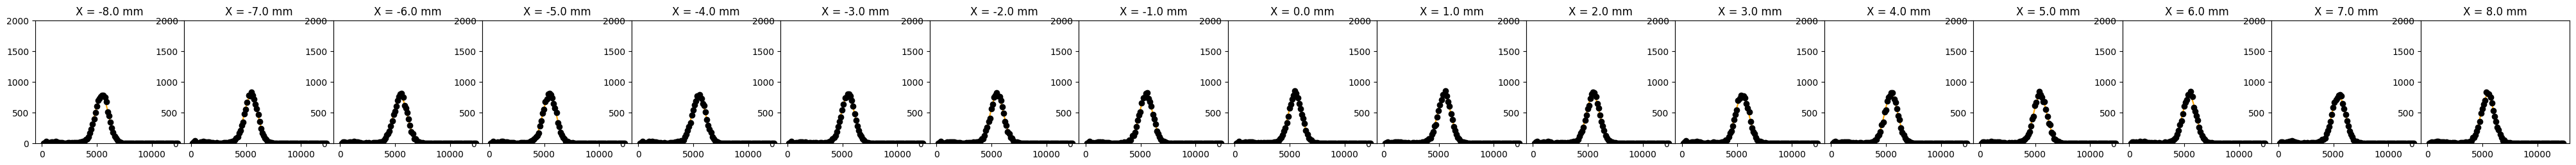

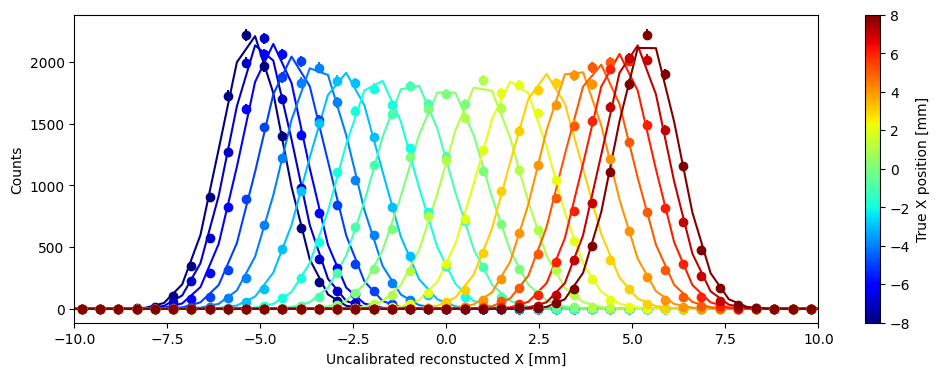

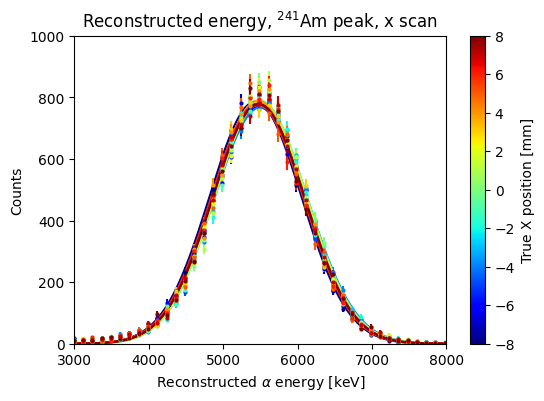

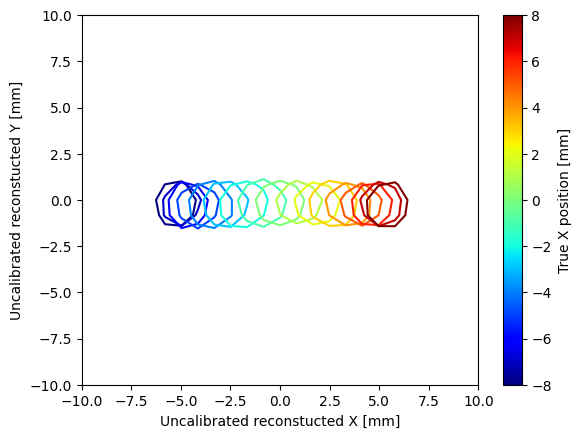

In [258]:
nrows = len(yval_list)
ncols = len(xval_list)

amp_fit_vals = np.zeros((nrows, ncols))
sig_fit_vals = np.zeros((nrows, ncols))
x_fit_vals = np.zeros((nrows, ncols))
y_fit_vals = np.zeros((nrows, ncols))
x_sig_vals = np.zeros((nrows, ncols))
y_sig_vals = np.zeros((nrows, ncols))

amp_fig = plt.figure(figsize=(ncols*3,nrows*2.5))
amp_fig_single = plt.figure(figsize=(6,4))
x_fig = plt.figure(figsize=(12,4))
y_fig = plt.figure(figsize=(12,4))

xy_fig = plt.figure()
xy_cal_fac = 3

remake_files = False

tscan = 500 ## time to scan around the template in ns
pts_to_scan = int(tscan*1e-9 * fsample * 0.5)
print("scanning +/-%d points"%pts_to_scan)

window  = [800, 1300]

sipm_coords_x = np.array([-6.5, 0, 6.5, -6.5, 0, 6.5, -6.5, 0, 6.5])
sipm_coords_y = np.array([6.5, 6.5, 6.5, 0, 0, 0, -6.5, -6.5, -6.5])

cmap = plt.cm.get_cmap('jet')
color_list = cmap(np.linspace(0,1,len(xval_list)))

for xidx, xpos in enumerate(xval_list):
    for yidx, ypos in enumerate(yval_list):

        if(remake_files):

            data_dict = {}
            wfidx = 0
            for fidx, fname in enumerate(filename_list):

                curr_xpos, curr_ypos = parse_position(fname)

                if(curr_xpos != xpos or curr_ypos != ypos):
                    continue

                with open(fname, 'rb') as fin:
                    curr_dict = pickle.load(fin)
                    for wf in curr_dict:
                        sum_waveform = np.zeros_like(time_vec)	
                        ## subtract baseline
                        baseline = 2048 
                        channel_dict = {}
                        for k, ch in enumerate(range(16,-1,-2)):
                            channel_dict[k] = wf[ch] - baseline
                            sum_waveform += (wf[ch] - baseline)

                        channel_dict[9] = sum_waveform

                        data_dict[wfidx] = channel_dict
                        wfidx += 1

            nwaveforms = wfidx
            print("Got %d waveforms"%nwaveforms + " for position: %.1f, %.1f"%(xpos, ypos))
            data_dict['time'] = time_vec*1e9

            mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

            recon_amps_max = []   
            recon_amps_fit = []  
            
            for k in data_dict.keys():
                if k == 'time': continue

                cdat_dict = data_dict[k]
                
                channel_max = np.zeros(10)
                channel_fit = np.zeros(10)
                for ch in range(10):

                    cdat = cdat_dict[ch]

                    shortened_temp = template_ch_dict[ov][ch][pts_to_scan:-pts_to_scan]

                    #fit = np.sum( cdat*template_ch_dict[ov][ch] ) / np.sum(template_ch_dict[ov][ch]**2)
                    fit_all = np.correlate(cdat, shortened_temp) / np.sum(shortened_temp**2)
                    fit = np.max(np.abs(fit_all))

                    midx = np.argmax(np.abs(cdat[mpts]))
                    max_val = cdat[mpts][midx]
                    
                    channel_max[ch] = max_val
                    channel_fit[ch] = fit
                
                recon_amps_max.append(channel_max)
                recon_amps_fit.append(channel_fit)

            np.savez( os.path.join(path, "recon_amps_%.1fV_%.1f_%.1f.npz"%(ov,xpos,ypos)), recon_amps_max=recon_amps_max, 
                                                                                      recon_amps_fit=recon_amps_fit,
                                                                                      nwaveforms=nwaveforms)
    
        else:
            data = np.load( os.path.join(path, "recon_amps_%.1fV_%.1f_%.1f.npz"%(ov,xpos,ypos)) )
            recon_amps_max = data['recon_amps_max']
            recon_amps_fit = data['recon_amps_fit']
            nwaveforms = data['nwaveforms']

        bins = np.linspace(0,12000 * (ov-24.7)/4.3, 100)
        bc = bins[:-1] + np.diff(bins)

        amps = recon_amps_fit
        recon_x = (amps[:,:9] @ sipm_coords_x.T)/np.sum(amps[:,:9], axis = 1)
        recon_y = (amps[:,:9] @ sipm_coords_y.T)/np.sum(amps[:,:9], axis = 1)
        h_fit, be = np.histogram( amps[:, 9], bins=bins )

        fpts = bc > 2000
        errs = np.sqrt(h_fit[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_fit), np.median(amps), np.std(amps)]
        gc_fit, _ = curve_fit(gauss, bc[fpts], h_fit[fpts], p0=spars, sigma=errs)

        peak_pts = np.abs(amps[:,9] - gc_fit[1]) < 2.5*np.abs(gc_fit[2])

        plt.figure(xy_fig.number)
        xbins = np.linspace(-12,12,30)
        ybins = np.linspace(-12,12,30)
        h2d, xedges, yedges = np.histogram2d(recon_x[peak_pts]*xy_cal_fac, recon_y[peak_pts]*xy_cal_fac, bins=(xbins,ybins))
        h2d /= np.max(h2d)
        xc = xedges[:-1] + np.diff(xedges)/2
        yc = yedges[:-1] + np.diff(yedges)/2
        CS = plt.contour(xc, yc, h2d.T, levels=[0.566], colors=[color_list[xidx]])
        CS.collections[0].set_label("x=%1.f mm"%xpos)

        eng_cal_fac = 1.34
        norm = 1
        xx = np.linspace(0, bc[-1], 1000)
        amp_fit_vals[yidx,xidx] = gc_fit[1]*eng_cal_fac
        sig_fit_vals[yidx,xidx] = gc_fit[2]*eng_cal_fac

        plt.figure(amp_fig.number)
        plt.subplot(nrows, ncols, yidx*ncols + xidx + 1)
        plt.errorbar(bc*eng_cal_fac, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko')
        plt.plot(xx*eng_cal_fac, gauss(xx, *gc_fit)/norm, 'orange')
        plt.ylim(0,2000)

        plt.figure(amp_fig_single)
        plt.errorbar(bc*eng_cal_fac, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='o', color=color_list[xidx], ms=2)
        plt.plot(xx*eng_cal_fac, gauss(xx, *gc_fit)/norm, color=color_list[xidx])
        plt.ylim(0,2000)

        x_bins = np.linspace(-12/xy_cal_fac, 12/xy_cal_fac, 50)
        h_x, bex = np.histogram( recon_x[peak_pts],  bins=x_bins)
        bcx = bex[:-1] + np.diff(bex)/2

        plt.figure(x_fig.number)
        plt.errorbar(bcx*xy_cal_fac, h_x/norm, yerr=np.sqrt(h_x)/norm, fmt='o', color=color_list[xidx])
        errs = np.sqrt(h_x)
        errs[errs==0] = 1
        spars = [np.max(h_x), np.median(recon_x[peak_pts]), np.std(recon_x[peak_pts])]
        gcx_fit, _ = curve_fit(gauss, bcx, h_x, p0=spars, sigma=errs)
        plt.plot(x_bins*xy_cal_fac, gauss(x_bins, *gcx_fit), color=color_list[xidx])
        x_fit_vals[yidx, xidx] = gcx_fit[1]
        x_sig_vals[yidx, xidx] = gcx_fit[2]


    for fig in [amp_fig,]:
        plt.figure(fig.number)
        if(yidx > 0):
            plt.gca().set_yticks([]) 
        else:
            plt.title("X = %.1f mm"%xpos)   
        if(xidx < nrows-1):
            plt.gca().set_xticks([])
    #if(row_idx == len())
    #plt.xlabel("Uncalib. pulse height (mV)")
    #plt.ylabel("Counts/s")
    #plt.title("Max of waveform")

#plt.subplot(1,2,1)
#plt.legend()

for fig in [amp_fig,]:
    plt.figure(fig.number)
    plt.subplots_adjust(hspace=0, wspace=0)

plt.figure(x_fig.number)
plt.xlim(-10,10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-8, vmax=8))
plt.colorbar(sm, ax=plt.gca(), label="True X position [mm]")
plt.xlabel("Uncalibrated reconstucted X [mm]")
plt.ylabel("Counts")
if(save_figs):
    plt.savefig(os.path.join(path, 'plots', 'x_position_scan_1d.png') )

plt.figure(amp_fig_single.number)
plt.title("Reconstructed energy, $^{241}$Am peak, x scan")
plt.colorbar(sm, ax=plt.gca(), label="True X position [mm]")
plt.xlabel(r"Reconstructed $\alpha$ energy [keV]")
plt.ylabel("Counts")
plt.xlim(3000,8000)
plt.ylim(0,1000)
if(save_figs):
    plt.savefig(os.path.join(path, 'plots', 'energy_position_scan_1d.png') )

plt.figure(xy_fig.number)
plt.colorbar(sm, ax=plt.gca(), label="True X position [mm]")
plt.xlabel("Uncalibrated reconstucted X [mm]")
plt.ylabel("Uncalibrated reconstucted Y [mm]")
plt.xlim(-10,10)
plt.ylim(-10,10)
if(save_figs):
    plt.savefig(os.path.join(path, 'plots', 'xy_position_scan_2d.png') )

plt.show()

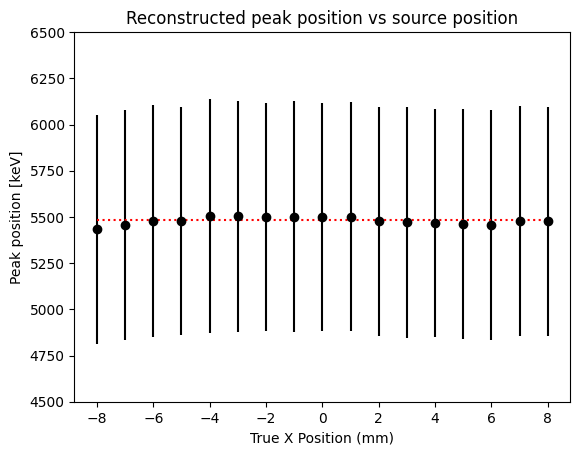

In [259]:
plt.figure()
plt.errorbar(xval_list, amp_fit_vals[0], yerr=np.abs(sig_fit_vals[0]), fmt='ko')
plt.plot(xval_list, np.ones_like(xval_list)*5486, 'r:')
plt.ylim(4500, 6500)
plt.xlabel("True X Position (mm)")
plt.ylabel("Peak position [keV]")
plt.title("Reconstructed peak position vs source position")

if(save_figs):
    plt.savefig(os.path.join(path, 'plots', 'eng_peak_position_scan_1d.png') )

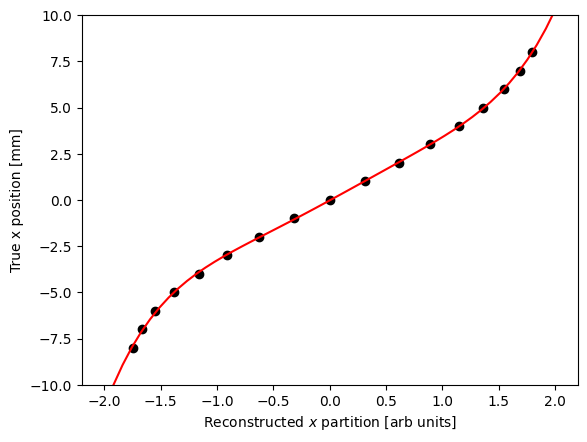

In [209]:
plt.figure()
plt.plot(x_fit_vals[0], xval_list, 'ko')
pvals = np.polyfit(x_fit_vals[0], xval_list, 5)

xx = np.linspace(-2, 2)
plt.plot(xx, np.polyval(pvals, xx), 'r')
plt.ylim(-10,10)
plt.xlabel("Reconstructed $x$ partition [arb units]")
plt.ylabel("True x position [mm]")

if(save_figs):
    plt.savefig(os.path.join(path, 'plots', 'peak_position_calibration.png') )


In [223]:
def split_gauss(x, A, mu, sig1, sig2):
    out_vals = A*np.exp(-(x-mu)**2/(2*sig1**2))
    right_vals = A*np.exp(-(x-mu)**2/(2*sig2**2))

    rpts = x > mu
    out_vals[rpts] = right_vals[rpts]

    return out_vals

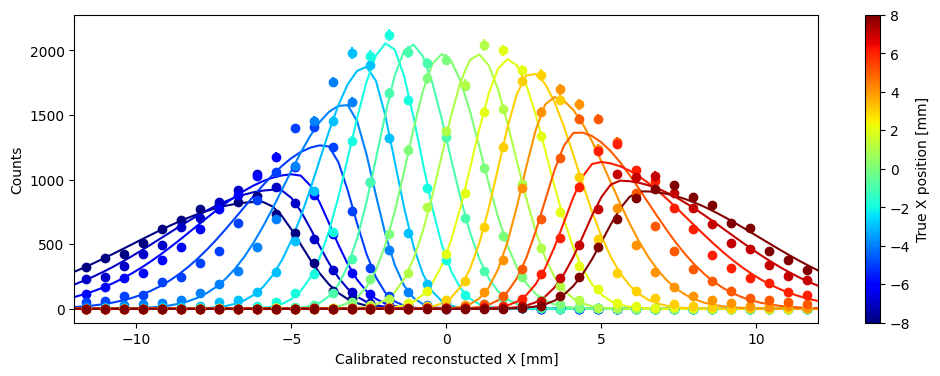

In [244]:
## now calibrated positions

xcalib_fig = plt.figure(figsize=(12,4))

x_calib_fit_vals = np.zeros((nrows, ncols))
y_calib_fit_vals = np.zeros((nrows, ncols))
x_calib_sig_lo_vals = np.zeros((nrows, ncols))
y_calib_sig_lo_vals = np.zeros((nrows, ncols))
x_calib_sig_hi_vals = np.zeros((nrows, ncols))
y_calib_sig_hi_vals = np.zeros((nrows, ncols))

for xidx, xpos in enumerate(xval_list):
    for yidx, ypos in enumerate(yval_list):

        data = np.load( os.path.join(path, "recon_amps_%.1fV_%.1f_%.1f.npz"%(ov,xpos,ypos)) )
        recon_amps_fit = data['recon_amps_fit']

        amps = recon_amps_fit
        recon_x = (amps[:,:9] @ sipm_coords_x.T)/np.sum(amps[:,:9], axis = 1)
        recon_y = (amps[:,:9] @ sipm_coords_y.T)/np.sum(amps[:,:9], axis = 1)

        calib_recon_x = np.polyval(pvals, recon_x)

        x_bins = np.linspace(-15, 15, 50)
        h_x, bex = np.histogram( calib_recon_x[peak_pts],  bins=x_bins)
        bcx = bex[:-1] + np.diff(bex)/2

        plt.figure(xcalib_fig.number)
        plt.errorbar(bcx, h_x/norm, yerr=np.sqrt(h_x)/norm, fmt='o', color=color_list[xidx])
        errs = np.sqrt(h_x)
        errs[errs==0] = 1
        spars = [np.max(h_x), np.median(calib_recon_x[peak_pts]), np.std(calib_recon_x[peak_pts]), np.std(calib_recon_x[peak_pts])]
        gcx_fit, _ = curve_fit(split_gauss, bcx, h_x, p0=spars, sigma=errs)
        xx = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.plot(xx, split_gauss(xx, *gcx_fit), color=color_list[xidx])
        x_calib_fit_vals[yidx, xidx] = gcx_fit[1]
        x_calib_sig_lo_vals[yidx, xidx] = np.abs(gcx_fit[2])
        x_calib_sig_hi_vals[yidx, xidx] = np.abs(gcx_fit[3])

plt.figure(xcalib_fig.number)
plt.xlim(-12,12)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-8, vmax=8))
plt.colorbar(sm, ax=plt.gca(), label="True X position [mm]")
plt.xlabel("Calibrated reconstucted X [mm]")
plt.ylabel("Counts")
if(save_figs):
    plt.savefig(os.path.join(path, 'plots', 'x_calib_position_scan_1d.png') )

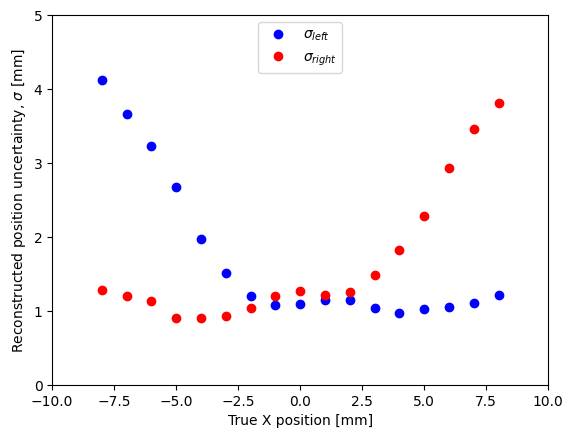

In [245]:
plt.figure()
plt.plot(xval_list, x_calib_sig_lo_vals[0], 'bo', label=r"$\sigma_{left}$")
plt.plot(xval_list, x_calib_sig_hi_vals[0], 'ro', label=r"$\sigma_{right}$")

plt.ylim(0,5)
plt.xlim(-10, 10)
plt.legend(loc='upper center')
plt.xlabel("True X position [mm]")
plt.ylabel(r"Reconstructed position uncertainty, $\sigma$ [mm]")
if(save_figs):
    plt.savefig(os.path.join(path, 'plots', 'x_calib_resolution_scan_1d.png') )

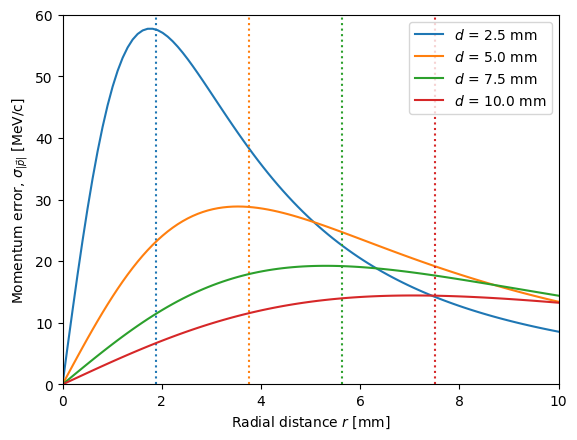

In [269]:
## now using the above, plot the momentum error

pmax = np.sqrt(2*4*8800) ## max momentum for Po-212 in MeV
dlist = np.array([2.5, 5, 7.5, 10]) ## mm
rlist = np.linspace(0, 10, 100)

plt.figure()
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
yy = [0, 60]
for i,d in enumerate(dlist):
    p_err = pmax * rlist*d/(rlist**2 + d**2)**1.5 * np.sqrt(2)

    solid_ang = 0.5 * (1 - d/np.sqrt(d**2 + rlist**2))
    rval = np.interp(0.1, solid_ang, rlist)
    plt.plot(rlist, p_err, label="$d$ = %.1f mm"%d, color=colors[i])
    plt.plot([rval, rval], yy, ":", color=colors[i])

plt.ylim(yy)
plt.xlim(0,10)
plt.xlabel("Radial distance $r$ [mm]")
plt.ylabel(r"Momentum error, $\sigma_{|\vec{p}|}$ [MeV/c]")
plt.legend()